# Transfer Learning

---

### Overview

- You will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

- A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

- The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

### Uses of Transfer Learning

- Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

- Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

![Transfer Learning](img/transfer.png)

![](img/xfer.png)

In [1]:
# pip install tensorflow_datasets

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

In [18]:
# load in cat vs dog dataset
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

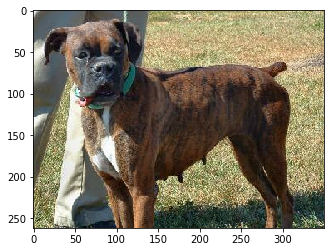

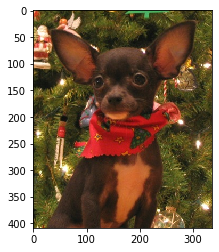

In [8]:
for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)

In [9]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [10]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [11]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [14]:
# it's grabbing 32 images and their labels at a time
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape, label_batch

(TensorShape([32, 160, 160, 3]),
 <tf.Tensor: shape=(32,), dtype=int64, numpy=
 array([0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 1, 0, 1])>)

### Transfer Learning

You will create the base model from the MobileNet V2 model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [16]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

- This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. See what it does to the example batch of images:

In [17]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


### Freezing Base Layers

In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all the layers.

In [20]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [23]:
# final - composite model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
# out of the 6 million total parameters, 2.2 million are frozen
# so we *ONLY* need to train 4 million parameters
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4096128   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 6,354,241
Trainable params: 4,096,257
Non-trainable params: 2,257,984
_________________________________________________________________


In [27]:
# before training, look at the accuracy
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 4s 212ms/step - loss: 0.8997 - accuracy: 0.5672


In [28]:
# training ...
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 212s 365ms/step - loss: 0.4509 - accuracy: 0.9305 - val_loss: 0.2844 - val_accuracy: 0.9622
Epoch 2/10
582/582 [==============================] - 213s 366ms/step - loss: 0.2718 - accuracy: 0.9551 - val_loss: 0.4920 - val_accuracy: 0.9347
Epoch 3/10
582/582 [==============================] - 262s 450ms/step - loss: 0.1682 - accuracy: 0.9667 - val_loss: 0.2433 - val_accuracy: 0.9579
Epoch 4/10
582/582 [==============================] - 271s 465ms/step - loss: 0.1306 - accuracy: 0.9702 - val_loss: 0.1288 - val_accuracy: 0.9789
Epoch 5/10
582/582 [==============================] - 284s 489ms/step - loss: 0.0990 - accuracy: 0.9738 - val_loss: 0.1224 - val_accuracy: 0.9781
Epoch 6/10
582/582 [==============================] - 298s 511ms/step - loss: 0.0727 - accuracy: 0.9773 - val_loss: 0.0957 - val_accuracy: 0.9789
Epoch 7/10
582/582 [==============================] - 303s 521ms/step - loss: 0.0536 - accuracy: 0.9817 - val_loss: 0.1355 -

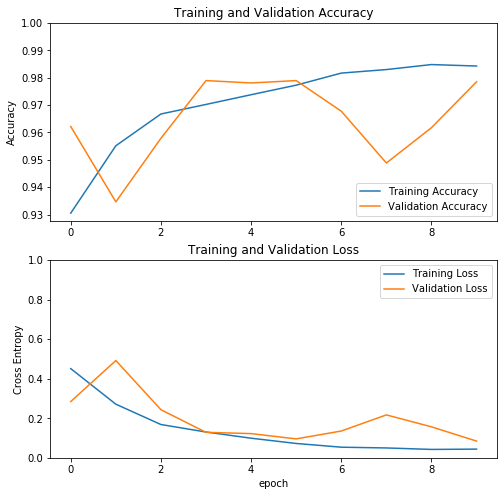

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()